In [1]:
import sys
import os

import os
cwd = os.getcwd()
root_path = os.path.abspath('..')
sys.path.insert(0, root_path)


In [2]:
import re
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.fs import RESULTS_RAW_DIR

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from utils.enums import Perspective

In [3]:
def get_latest_runs(n):
    def is_numeric(input):
        try:
            float(input)
            return True
        except ValueError:
            return False
        
    # Filter numeric folder names
    numeric_folders = [folder for folder in os.listdir(RESULTS_RAW_DIR) if is_numeric(folder) and os.path.isdir(os.path.join(RESULTS_RAW_DIR, folder))]

    if numeric_folders:
        # Sort folders by their numeric value, in descending order
        sorted_folders = sorted(numeric_folders, key=lambda x: float(x), reverse=True)
        
        # Get the latest n runs
        latest_n_runs = sorted_folders[:n]
        
        print(f"The latest {n} runs are: {latest_n_runs}")
        return latest_n_runs
    else:
        print("No runs found.")
        return None

In [4]:
import os

def list_subfolders(experiment_name):
    experiment_path = os.path.join(RESULTS_RAW_DIR, experiment_name)
    # Get all subfolder names in the specified directory
    run_names = [name for name in os.listdir(experiment_path) if os.path.isdir(os.path.join(experiment_path, name))]
    return run_names

In [5]:
def load_results(run_name, verbose=False,directory=None):
    if directory:
        run_path = os.path.join(RESULTS_RAW_DIR, directory, run_name)
    else:
        run_path = os.path.join(RESULTS_RAW_DIR, run_name)
    npy_files = [file for file in os.listdir(run_path) if file.endswith('.npy')]

    loaded_data = {}

    # Load each .npy file and use the file name (without extension) as the key
    for npy_file in npy_files:
        file_path = os.path.join(run_path, npy_file)
        key = os.path.splitext(npy_file)[0]  # Get the file name without .npy extension
        loaded_data[key] = np.load(file_path)

        if verbose: print(f"{loaded_data[key].shape} \t {key}")

    return loaded_data

In [6]:
def get_buckets(keys):
    buckets = set()
    for key in keys:
        numbers = re.findall(r'\d+', key)
        buckets.update(map(int, numbers))
    if len(buckets) > 0:
        return sorted(buckets)
    else:
        return None

In [7]:
from sklearn.metrics import precision_recall_curve

def filter(list, string):
    return [item for item in list if string in item]

def calculate_f1(precision, recall):
    # Check if both precision and recall are zero to avoid division by zero
    precision[precision == 0] = 1e-6
    recall[recall == 0] = 1e-6

    if np.any(precision != 0) and np.any(recall != 0):
        return (2 * precision * recall) / (precision + recall)
    else:
        return 0
    
def _calculate_results(perspective_index, perspective, bucket, level, level_label_keys, level_result_keys, results, verbose):
    if verbose: print(perspective_index, perspective)

    # Get the key names
    if bucket is not None:
        true_key = filter(level_label_keys, f'_{bucket}')
        pred_prob_key = filter(level_result_keys, f'{perspective}_{bucket}')
    else:
        true_key = level_label_keys
        pred_prob_key = filter(level_result_keys, f'{perspective}')
    if verbose: print(true_key, pred_prob_key)

    # Check if the files exist by checking the length
    if len(true_key) != 1 or len(pred_prob_key) != 1:
        if verbose: print(f'Skipping as {perspective} has not been found.')
        return None
    else:
        true_key = true_key[0]
        pred_prob_key = pred_prob_key[0]
        if verbose: print(true_key, pred_prob_key)

    # Get the values by key
    pred_prob = np.array(results[pred_prob_key],dtype=np.float32)
    if level == 'trace':
        y_true = np.array(results[true_key][:,perspective_index],dtype=np.float32)
    elif level == 'event':
        # Also need to take the bucket_size into account
        if bucket is None:
            y_true = np.array(results[true_key][:,:,perspective_index],dtype=np.float32)
        else:
            y_true = np.array(results[true_key][:,:bucket,perspective_index],dtype=np.float32)
    else: #attribute
        if bucket is None:
            y_true = np.array(results[true_key][:,:,:,perspective_index],dtype=np.float32)
        else:
            y_true = np.array(results[true_key][:,:bucket,:,perspective_index],dtype=np.float32)

    if verbose: print(y_true.shape, pred_prob.shape)

    y_true = y_true.flatten()
    pred_prob = pred_prob.flatten()

    # Check if all y_true values are 0 (most likely indicates a problem with an earlier step)
    if np.all(y_true == 0):
        if verbose: print(f'No positive class found for {true_key},{pred_prob_key}')
        return None

    # print(true, len(true))
    # print(pred_prob, len(pred_prob))
    if verbose: print(y_true.shape, pred_prob.shape)

    precision, recall, thresholds = precision_recall_curve(y_true=y_true, probas_pred=pred_prob)
    # print(precision.shape)
    # print(recall.shape)
    f1s=calculate_f1(precision,recall)
    f1s[np.isnan(f1s)] = 0
    # print(f1s)
    best_index=np.argmax(f1s)
    # if True: print(best_index, len(f1s), f1s[best_index])
    return (pred_prob_key,f1s[best_index],thresholds[best_index])

def calculate_results(results, level, verbose=False):
    level_file_keys = filter(results.keys(), level)
    level_label_keys = filter(level_file_keys, 'label')
    level_result_keys = filter(level_file_keys, 'result')
    bucket_lengths = get_buckets(level_file_keys)

    if verbose: print(results.keys())

    f1_scores = []
    for perspective_index, perspective in enumerate(Perspective.values()):
        if bucket_lengths is None:
            f1_score = _calculate_results(perspective_index, perspective, None, level, level_label_keys, level_result_keys, results, verbose)
            if f1_score is not None:
                f1_scores.append(f1_score)
        else:
            for bucket in bucket_lengths:
                f1_score = _calculate_results(perspective_index, perspective, bucket, level, level_label_keys, level_result_keys, results, verbose)
                if f1_score is not None:
                    f1_scores.append(f1_score)
    return f1_scores

In [8]:
def plot_f1_scores(title, label_list, results_lists, legend=True):
    # Prepare the data for multiple lists
    all_names = set()
    for trace_results in results_lists:
        all_names.update([item[0] for item in trace_results])
    
    all_names = sorted(all_names)  # Sort names to maintain consistency in bar positions
    name_indices = np.arange(len(all_names))  # Create an index for each name
    
    # Initialize plot
    plt.figure(figsize=(6, 6))
    # bar_width = 0.2  # Set the width of each bar
    offset = 0  # To shift bars for different lists
    num_lists = len(results_lists)
    bar_width = 0.9 / num_lists  # Reduce bar width based on the number of lists
    # offset = -(bar_width * num_lists) / 2  # Start offset for centering the bars
    
    # Plot bars for each result list
    for i, (label, trace_results) in enumerate(zip(label_list, results_lists)):
        names = [item[0] for item in trace_results]
        values = [item[1] for item in trace_results]
        
        # Align the values with all possible names, filling in 0 for missing values
        aligned_values = [values[names.index(name)] if name in names else 0 for name in all_names]
        
        # Create the bar chart with offset
        plt.barh(name_indices + offset, aligned_values, bar_width, label=label)
        offset += bar_width  # Update the offset for the next set of bars
    
    # Set labels, ticks, and title
    plt.xlabel('F1 Score')
    plt.ylabel('Trace Results')
    plt.yticks(name_indices + bar_width / 2, all_names)  # Center ticks between bars
    plt.title(f'Bar Chart of {title}')
    if legend:
        plt.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()

In [9]:
num_bar_range = range(35)
num_bar_large_range = range(14)
colors = ['red', 'blue', 'green', 'orange', 'purple']
bar_colors = [colors[i // 5 % len(colors)] for i in num_bar_range] + [colors[0]] + [colors[i // 7 % len(colors) + 1] for i in num_bar_large_range]

In [10]:
len(bar_colors)

50

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_f1_scores_simple(run_list, name_list, title):
    num_bar_range = range(len(run_list))
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    bar_colors = [colors[i // 5 % len(colors)] for i in num_bar_range]

    plt.figure(figsize=(10, 6))
    plt.bar(num_bar_range, run_list, color=bar_colors)

    plt.xticks(num_bar_range, name_list, rotation=90) 

    plt.xlabel("Configurations")
    plt.ylabel("F1 Score")
    plt.title(f'Bar Chart of {title}')

    plt.show()

In [12]:
def analyze_run(run_list,name_list,title,verbose=False,directory=None,legend=True):
    results_traces = []
    results_events = []
    results_attributes = []
    for run in run_list:
        results = load_results(run_name=run, verbose=verbose,directory=directory)

        results_traces.append(calculate_results(results, 'trace', verbose=verbose))
        results_events.append(calculate_results(results, 'event', verbose=verbose))
        #results_traces.append(f1_scores_attributes = calculate_results(results, 'attribute', verbose=True))

    results_traces = np.array(results_traces)[:,:,1]
    results_events = np.array(results_events)[:,:,1]

    results_traces = np.array(results_traces, dtype=float)
    results_events = np.array(results_events, dtype=float)

    results_traces = np.mean(results_traces, axis=1)
    results_events = np.mean(results_events, axis=1)

    print(results_traces.shape)
    print(results_events.shape)

    name_list = np.append(name_list, ["TRANSFORMER"])
    results_traces = np.append(results_traces, [0.13878])
    results_events = np.append(results_events, [0])

    plot_f1_scores_simple(results_traces,name_list,title)
    plot_f1_scores_simple(results_events,name_list,title)

    # plot_f1_scores(title=f'Trace Level - {title}', label_list=name_list, results_lists=results_traces, legend=legend)
    # plot_f1_scores(title=f'Event Level - {title}', label_list=name_list, results_lists=results_events, legend=legend)
    # plot_f1_scores(title=f'Attribute Level -  {title}', name_list=name_list, results_lists=results_attributes)

In [13]:
# Usage example
directory = "DAE_Finetuned_Embedding"  # Replace with your folder path
run_list = list_subfolders(directory)
print(run_list)

['24-10-31-11-01', '24-10-31-11-03', '24-10-31-11-04', '24-10-31-11-06', '24-10-31-11-07', '24-10-31-11-09', '24-10-31-11-10', '24-10-31-11-12', '24-10-31-11-14', '24-10-31-11-16', '24-10-31-11-17', '24-10-31-11-19', '24-10-31-11-20', '24-10-31-11-22', '24-10-31-11-23', '24-10-31-11-25', '24-10-31-11-26', '24-10-31-11-28', '24-10-31-11-29', '24-10-31-11-30', '24-10-31-11-32', '24-10-31-11-33', '24-10-31-11-35', '24-10-31-11-36', '24-10-31-11-38', '24-10-31-11-39', '24-10-31-11-42', '24-10-31-11-45', '24-10-31-11-48', '24-10-31-11-51']


In [14]:
name_list = []
repeats = 5

for repeat in range(repeats):
    name_list.append(f"DAE_ONE_HOT_{repeat}")
for repeat in range(repeats):
    name_list.append(f"DAE_FIXED_VECTOR_{repeat}")
for repeat in range(repeats):
    name_list.append(f"DAE_W2V_ATC_{repeat}_(20,2)")
for repeat in range(repeats):
    name_list.append(f"DAE_W2V_ATC_{repeat}_(200,10)")
for repeat in range(repeats):
    name_list.append(f"DAE_W2V_C_{repeat}_(20,2)")
for repeat in range(repeats):
    name_list.append(f"DAE_W2V_C_{repeat}_(200,10)")

print(len(name_list))
print(len(run_list))

30
30


(30,)
(30,)


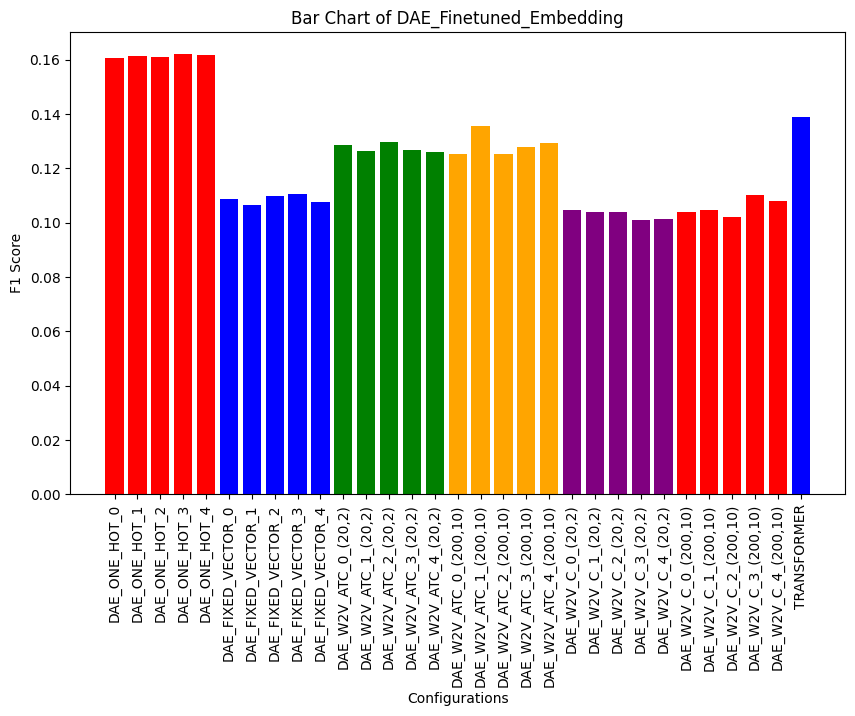

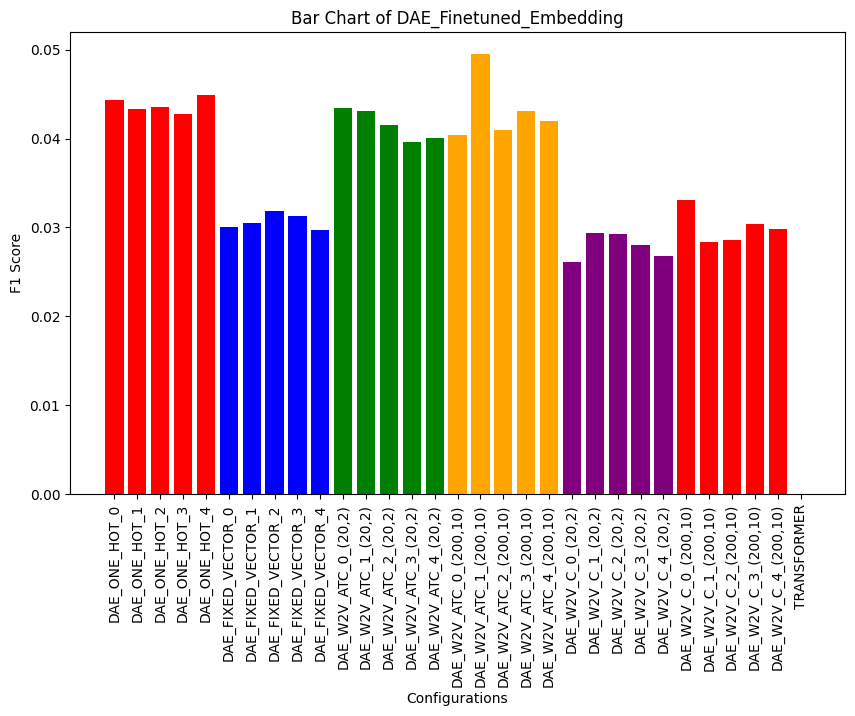

In [15]:
# Batch size 1 no workload and arrival-time
analyze_run(run_list=run_list,name_list=name_list,title=directory,directory=directory,legend=False)